In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

%matplotlib inline
np.random.seed(45)
tf.random.set_seed(45)

For this chapter I'll take a different approach. Mostly read the book and type relevant code snippets in the notebook. Hopefully will be much faster.

## Forecasting a time series

Let's define a function to generate a time series

In [2]:
BATCH_SIZE = 3

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) -0.5)  # add a bit of noise
    return series[..., np.newaxis].astype(np.float32)

series = generate_time_series(BATCH_SIZE, 50)

A sample of how they look. In these examples we're tipically interested in predicting the next value in the time series (marked with the green x)

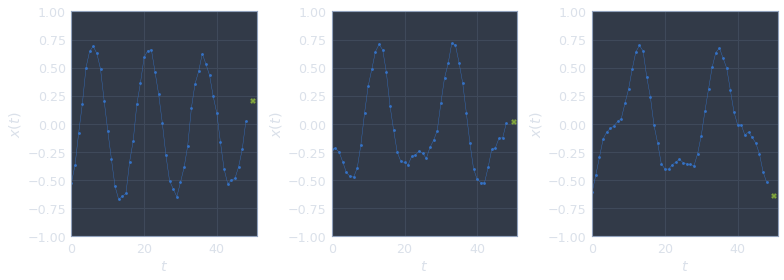

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=BATCH_SIZE, figsize=(11,4))

for idx, ax in enumerate(axes):
    ts = series[idx]
    x_axis = range(len(ts[:-1]))
    ax.plot(x_axis, ts[:-1], linewidth=0.4, marker='.')
    ax.plot(len(ts[:-1])+1, ts[-1], marker='X')
    
    ax.set_ylabel('$x(t)$')
    ax.set_xlabel('$t$')
    ax.set_xlim(left=0, right=len(ts) + 1)
    ax.set_ylim(bottom=-1, top=1)

    fig.tight_layout()

Let's create some datasets!

In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
X_train.shape

(7000, 50, 1)

### Baseline Metrics

The simplest appreach we can take for prediction, is simply to predict the last value just seen. Let's use that and calculate the mean squared error

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02044728

Another approach we can take is to create a simple fully connected network to create a linar regression model. Each prediction will be a linear combination of the values in the time series

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1322 - val_loss: 0.0677
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0298
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0182
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 0.0135
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0130 - val_loss: 0.0111
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0060

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.history.history['val_loss'][-1]

0.003824253100901842

Much better loss!

### Implementing a SimpleRNN

Time series are tipycally represented as 3D arrays of shape [batch_size, time_steps, dimensionality], where dimensinality is 1 for univariate time series. Keras' SimpleRNN uses tanh as the default activation for these layers

In [10]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) 
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1581 - val_loss: 0.1467
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1437 - val_loss: 0.1442
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1423 - val_loss: 0.1434
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1415 - val_loss: 0.1451
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1421 - val_loss: 0.1441
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1419 - val_loss: 0.1450
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1421 - val_loss: 0.1465
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1418 - val_loss: 0.1446
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1416 - val_loss: 0.1434
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.1414 - val_loss: 0.1446

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.history.history['val_loss'][-1]

0.14560788869857788

**Note on Trend and Seasonality**

Other time series models such as ARIMA require you to detrend and remove seasonality from your data prior to fitting. When using RNNs it is usually not necessary to do this but it may improve performance in some cases as the model will not have to learn the trend or the seasonality

### Deep RNNs

We can stack SimpleRNNS to create deeper models. Note we use ```return_sequences=True``` so that each intermediate layer returns a 3D array conrainig outputs for all time steps

In [13]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 6s 26ms/step - loss: 0.0558 - val_loss: 0.0086
Epoch 2/5
219/219 [==============================] - 5s 25ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 3/5
219/219 [==============================] - 5s 25ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 4/5
219/219 [==============================] - 5s 24ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/5
219/219 [==============================] - 5s 24ms/step - loss: 0.0038 - val_loss: 0.0034


The last layer is a bit inneficient since it's just a single RNN unit. We could replace it with a Dense layer which would allow us to use any activation, with the model performing just as well.

In [14]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 4s 19ms/step - loss: 0.0253 - val_loss: 0.0060
Epoch 2/5
219/219 [==============================] - 4s 18ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 3/5
219/219 [==============================] - 4s 18ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/5
219/219 [==============================] - 5s 22ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/5
219/219 [==============================] - 5s 24ms/step - loss: 0.0032 - val_loss: 0.0032


### Forecasting Several Time Steps Ahead

If we want to predict the next 10 values in the time series, one approach we can take is to predict the next value, add that to the inputs, then predict the next one, add that to inputs and so on. The downside with this approach is that prediction for later steps will be less accurate (errors might accumulate)

In [16]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

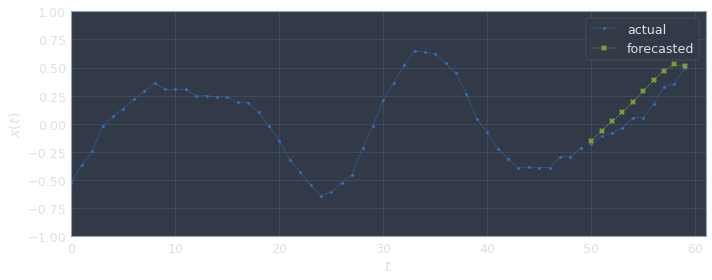

In [17]:
fig, ax = plt.subplots(figsize=(10,4))

t = range(n_steps)
ax.plot(t, X_new[0, :, 0], linewidth=0.4, marker='.')

actual_vals = series[0, n_steps:, 0]
ax.plot(range(n_steps, 60), actual_vals, linewidth=0.4, marker='.', c='b', label='actual')

ax.plot(range(n_steps, 60), Y_pred[0, :, 0], linewidth=0.4, marker='X', c='g', label='forecasted')

ax.set_ylabel('$x(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(left=0, right=n_steps + 10 + 1)
ax.set_ylim(bottom=-1, top=1)
ax.legend()

fig.tight_layout()

An alternative is to train an RNN to predict all 10 next values at once. This requires us to change the target vectors to contain the next 10 values

In [18]:
series = generate_time_series(10000, n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

And change the outputs to have 10 units instead of 1

In [19]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 5s 21ms/step - loss: 0.1590 - val_loss: 0.1452
Epoch 2/5
219/219 [==============================] - 4s 18ms/step - loss: 0.1444 - val_loss: 0.1445
Epoch 3/5
219/219 [==============================] - 4s 19ms/step - loss: 0.1439 - val_loss: 0.1442
Epoch 4/5
219/219 [==============================] - 4s 18ms/step - loss: 0.1436 - val_loss: 0.1443
Epoch 5/5
219/219 [==============================] - 4s 19ms/step - loss: 0.1437 - val_loss: 0.1440


In [20]:
Y_pred = model.predict(X_new)

Let's convert this model to a sequence-to-sequence model. Book pg 510 for description

In [21]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [22]:
Y_train.shape

(7000, 50, 10)

Now we  add ```return_sequences``` to all layers and introduce a ```TimeDistributed``` layer. It wraps any layer and applies it at each step of a time sequence.

We will also use a custom metric to compute the MSE over the output at the last time step

In [23]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss='mean_squared_error', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0495 - last_time_step_mse: 0.0374 - val_loss: 0.0379 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0359 - last_time_step_mse: 0.0230 - val_loss: 0.0407 - val_last_time_step_mse: 0.0288
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0320 - last_time_step_mse: 0.0200 - val_loss: 0.0335 - val_last_time_step_mse: 0.0221
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0296 - last_time_step_mse: 0.0178 - val_loss: 0.0288 - val_last_time_step_mse: 0.0165
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0284 - last_time_step_mse: 0.0162 - val_loss: 0.0271 - val_last_time_step_mse: 0.0146
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0258 - last_time_step_mse: 0.0135 - val_loss: 0.0246 - val_last_time_step_mse: 0.0126
Epoch 7/20
219/219 [==

Tip: When forecasting time series, it is often useful to have some error bars along with your predictions. For this, an efficient technique is MC Dropout: add an MC Dropout layer within each memory cell, dropping part of the inputs and hidden states. After training, to forecast a new time series, use the model many times and compute the mean and standard deviation of the predictions at each time step.

## Handling Long Sequences

### Fighting the unstable gradients problem

Batch normalization doesn't work as effectively in RNNs. An alternative is to use Layer normalization which normalizes across the features dimension instead of the batch dimension. Below a custom implementation os a SimpleRNNCell which applies Layer Normalization at each step

In [24]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [25]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
...

Ellipsis

### LSTM Cells

LSTM cells fight the short-term memory problem: Due to the transformations that occur in an RNN, information is lost at each time step. After a while the RNN has virtually no trace of the first input.

In Keras the ```LSTM``` layer uses an optimized implementation when running on GPU

In [26]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
    
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss='mean_squared_error', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0465 - last_time_step_mse: 0.0314 - val_loss: 0.0295 - val_last_time_step_mse: 0.0126
Epoch 2/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0272 - last_time_step_mse: 0.0117 - val_loss: 0.0246 - val_last_time_step_mse: 0.0089
Epoch 3/20
219/219 [==============================] - 10s 43ms/step - loss: 0.0216 - last_time_step_mse: 0.0065 - val_loss: 0.0204 - val_last_time_step_mse: 0.0054
Epoch 4/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0183 - last_time_step_mse: 0.0046 - val_loss: 0.0183 - val_last_time_step_mse: 0.0049
Epoch 5/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0169 - last_time_step_mse: 0.0043 - val_loss: 0.0168 - val_last_time_step_mse: 0.0037
Epoch 6/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0160 - last_time_step_mse: 0.0039 - val_loss: 0.0166 - val_last_time_step_mse: 0.0046
Epoch 7/20
219/21

The sigmoid (logistic) layers on a LSTM act as 'soft-gates'. Since their output ranges between 0 and 1, whenever they are applied to another matrix via element-wise multiplication (or addition), they will scale the corresponding weights, diminishing what we want to forget and augmenting what we want to add.

[Colah's blog on LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Unreasonable effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[Gated Recurrent Units](https://arxiv.org/abs/1406.1078) (GRU's) are a variation of LSTM. They combaine the forget and input gate. Whenever a memory must be stored, the location of storage is completely erased beforehand.

### Using 1D convolutional Layers to Process Sequences

In [27]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0686 - last_time_step_mse: 0.0600 - val_loss: 0.0482 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0398 - last_time_step_mse: 0.0329 - val_loss: 0.0353 - val_last_time_step_mse: 0.0265
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0310 - last_time_step_mse: 0.0226 - val_loss: 0.0283 - val_last_time_step_mse: 0.0180
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0264 - last_time_step_mse: 0.0162 - val_loss: 0.0255 - val_last_time_step_mse: 0.0142
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0244 - last_time_step_mse: 0.0137 - val_loss: 0.0241 - val_last_time_step_mse: 0.0128
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0231 - last_time_step_mse: 0.0122 - val_loss: 0.0230 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/219 [==

### [WaveNet](https://arxiv.org/abs/1609.03499)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0701 - last_time_step_mse: 0.0599 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0324 - last_time_step_mse: 0.0196 - val_loss: 0.0305 - val_last_time_step_mse: 0.0175
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0285 - last_time_step_mse: 0.0163 - val_loss: 0.0280 - val_last_time_step_mse: 0.0151
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0266 - last_time_step_mse: 0.0145 - val_loss: 0.0262 - val_last_time_step_mse: 0.0135
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0253 - last_time_step_mse: 0.0134 - val_loss: 0.0254 - val_last_time_step_mse: 0.0131
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0244 - last_time_step_mse: 0.0125 - val_loss: 0.0242 - val_last_time_step_mse: 0.0117
Epoch 7/20
219/219 [==